In [7]:
# activiate inline plotting
%pylab inline
# load modules
import sys
import scipy as SP
import pylab as PL
from matplotlib import cm
import h5py
import os
import GPy
import numpy as np

#adjust path
scLVM_BASE = '/Users/jiwang/anaconda3/envs/scLVM/lib/python2.7/site-packages/'
from scLVM import scLVM

sys.path.append('/Users/jiwang/anaconda3/envs/scLVM/')
#sys.path.append( scLVM_BASE +'..')
sys.path.append(scLVM_BASE + 'scLVM/utils') #this is not included in the github repo
#sys.path.append(scLVM_BASE +'CFG')
#from misc import *
#from barplot import *
#from default import *
#from scLVM.utils.barplot import *
#from scLVM.utils.misc import *

from IPython.display import Latex

Populating the interactive namespace from numpy and matplotlib


In [4]:
?scLVM.fitGPLVM

In [13]:
Y = numpy.loadtxt("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/gene_expression_matrx_4scLVM.txt", delimiter='\t')                  # gene expression matrix
tech_noise = numpy.loadtxt("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/tech_noise_4scLVM.txt", delimiter='\t')
genesID = numpy.loadtxt("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/geneNames_4scLVM.txt", delimiter='\t')
genes_het_bool = numpy.loadtxt("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/index_hetgenes_4scLVM.txt", delimiter='\t')
idx_cell_cycle = numpy.loadtxt("/Volumes/groups/cochella/jiwang/Projects/Aleks/scRNAseq_MS_lineage/results/R6875_R7116_R7130_R7130redo_R7133_scRNA_v1_20190506/tables/index_ccgenes_4scLVM.txt", delimiter='\t')

#tech_noise = f['LogVar_techMmus'][:]       # technical noise
#genes_het_bool=f['genes_heterogen'][:]     # index of heterogeneous genes
#geneID = f['gene_names'][:]            # gene names
#cellcyclegenes_filter = SP.unique(f['cellcyclegenes_filter'][:].ravel() -1) # idx of cell cycle genes from GO
#cellcyclegenes_filterCB = f['ccCBall_gene_indices'][:].ravel() -1        # idx of cell cycle genes from cycle base ...

ValueError: could not convert string to float: aap-1

In [4]:
# filter cell cycle genes
#idx_cell_cycle = SP.union1d(cellcyclegenes_filter,cellcyclegenes_filterCB)
# determine non-zero counts
idx_nonzero = SP.nonzero((Y.mean(0)**2)>0)[0]
idx_cell_cycle_noise_filtered = SP.intersect1d(idx_cell_cycle,idx_nonzero)
# subset gene expression matrix
Ycc = Y[:,idx_cell_cycle_noise_filtered]

Text(0,0.5,'cells')

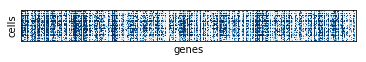

In [5]:
plt = PL.subplot(1,1,1)
PL.imshow(Ycc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
#PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('genes')
PL.ylabel('cells')

In [6]:
k = 80                    # number of latent factors
out_dir = scLVM_BASE + 'cache'       # folder where results are cached
file_name = 'Kcc.hdf5'    # name of the cache file
recalc = True             # recalculate X and Kconf
use_ard = True            # use automatic relevance detection
sclvm = scLVM(Y)
#Fit model with 80 factors
X_ARD,Kcc_ARD,varGPLVM_ARD = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=k,out_dir=out_dir,file_name=file_name,recalc=recalc, use_ard=use_ard)


Text(0,0.5,'Variance explained')

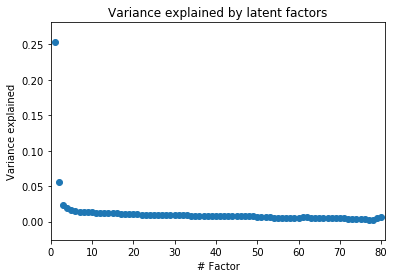

In [7]:
#Plot variance contributions from ARD 
plt = PL.subplot(1,1,1)
PL.title('Variance explained by latent factors')
PL.scatter(SP.arange(k)+1,varGPLVM_ARD['X_ARD'])
PL.xlim([0,k+1])
PL.xlabel('# Factor')
PL.ylabel('Variance explained')

In [8]:
#Fit model with a single factor (rank 1 covariance matrix)
X,Kcc,varGPLVM = sclvm.fitGPLVM(idx=idx_cell_cycle_noise_filtered,k=1,out_dir='./cache',file_name=file_name,recalc=True, use_ard=False)

Text(0,0.5,'cells')

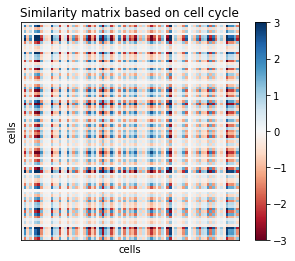

In [9]:
#Plot inferred similarity matrix
plt = PL.subplot(1,1,1)
PL.title('Similarity matrix based on cell cycle')
PL.imshow(Kcc,cmap=cm.RdBu,vmin=-3,vmax=+3,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('cells')
PL.ylabel('cells')

In [10]:
# considers only heterogeneous genes
Ihet = genes_het_bool==1
Y    = Y[:,Ihet]
tech_noise = tech_noise[Ihet]
geneID = geneID[Ihet]

In [11]:
#optionally: restrict range for the analysis
i0 = 0    # gene from which the analysis starts
i1 = 2000 # gene at which the analysis ends 

# construct sclvm object
sclvm = scLVM(Y,geneID=geneID,tech_noise=tech_noise)

# fit the model from i0 to i1
sclvm.varianceDecomposition(K=Kcc,i0=i0,i1=i1)

In [12]:
normalize=True    # variance components are normalizaed to sum up to one

# get variance components
var, var_info = sclvm.getVarianceComponents(normalize=normalize)
var_filtered = var[var_info['conv']] # filter out genes for which vd has not converged

# get corrected expression levels
Ycorr = sclvm.getCorrectedExpression()
Ycorr.shape

(81, 2000)

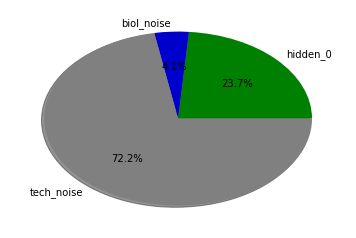

In [13]:
#calculate average variance components across all genes and visualize
var_mean = var_filtered.mean(0)
colors = ['Green','MediumBlue','Gray']
pp=PL.pie(var_mean,labels=var_info['col_header'],autopct='%1.1f%%',colors=colors,
       shadow=True, startangle=0)

In [14]:
H2=1-var_filtered[:,2]
var_comp_fileds = SP.array([[0, 'cell cycle', 'Peru'],
       [1, 'biol. var', 'DarkMagenta'],
       [2, 'tech. var', '#92c5de']], dtype=object)
var_plot(var_filtered,H2,var_comp_fileds,normalize=True, figsize=[5,4])

NameError: name 'var_plot' is not defined

In [15]:
i0 = 0     # gene from which the analysis starts
i1 = 10    # gene to which the analysis ends

# fit lmm without correction
pv0,beta0,info0 = sclvm.fitLMM(K=None,i0=i0,i1=i1,verbose=False)
# fit lmm with correction
pv1,beta1,info1 = sclvm.fitLMM(K=Kcc,i0=i0,i1=i1,verbose=False)

AttributeError: 'module' object has no attribute 'test_lmm'

NameError: name 'beta0' is not defined

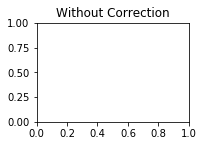

In [16]:
plt=PL.subplot(2,2,1)
PL.title('Without Correction')
p=PL.imshow(beta0[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')
plt=PL.subplot(2,2,2)
PL.title('With Correction')
p=PL.imshow(beta1[:,i0:i1],cmap=cm.RdBu,vmin=-0.6,vmax=+1,interpolation='None')
PL.colorbar()
plt.set_xticks([])
plt.set_yticks([])
PL.xlabel('gene'),PL.ylabel('gene')

In [17]:
SP.savetxt('Ycorr.txt',Ycorr)

In [18]:
# Model optimization
Ystd = Ycorr-Ycorr.mean(0)
Ystd/=Ystd.std(0)
input_dim = 2 # How many latent dimensions to use
kern = GPy.kern.RBF(input_dim,ARD=True) # ARD kernel
m = GPy.models.BayesianGPLVM(Ystd, input_dim=input_dim, kernel=kern, num_inducing=40)
m.optimize('scg', messages=0, max_iters=2000)


[<BarContainer object of 2 artists>]

 /Users/jiwang/anaconda3/envs/scLVM/lib/python2.7/site-packages/matplotlib/figure.py:2299: UserWarning:This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


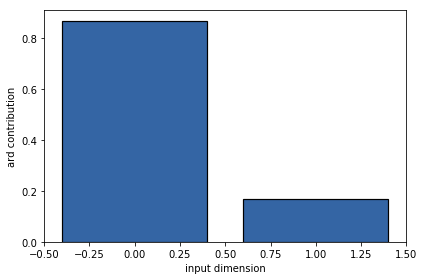

In [19]:
m.kern.plot_ARD()

In [20]:
i_Gata3 = SP.where(geneID=='ENSMUSG00000015619')
color = Ycorr[:,i_Gata3]
#color = Ycorr[:,0]
PL.scatter(m.X[:,0]['mean'], m.X[:,1]['mean'], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

AttributeError: 'Param' object has no attribute '_Parameterizable__visited'

In [21]:
[S,W] = PCA(Ystd,2)

NameError: name 'PCA' is not defined

In [22]:
PL.scatter(S[:,0],S[:,1], 40, color)
PL.xlabel('PC1')
PL.ylabel('PC2')
PL.colorbar()

NameError: name 'S' is not defined